In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import gdspy
ld_AP = {"layer":74, "datatype": 0}

In [238]:
lib = gdspy.GdsLibrary(infile='AL_AP_artwork_test.gds', unit = 1e-9)
cell = lib.cells['AL_AP_artwork_test']
for sq in boundary_output:
    rect = gdspy.Rectangle((sq[0]/1000.0,1000-sq[2]/1000.0),(sq[1]/1000.0,1000-sq[3]/1000.0),**ld_AP)
    cell.add(rect)
cell.write_svg('Test.svg')
lib.write_gds('AL_AP_artwork_output.gds')


In [242]:

len(cell.get_polygons())

396

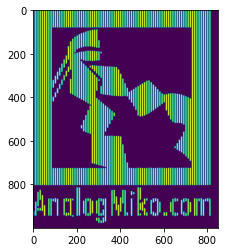

In [110]:
imgname = 'AMK'

k = Image.open(imgname+'.png').convert('L')
ksize = k.size
k_target_h = 85; # Unit is 5 um, Physical Size: 425 um
k_scaling  = k_target_h/ksize[0]
ksize1 = np.dot(ksize,k_scaling).astype(int)
ksize2 = [ksize1[0],    ksize1[1]*10]
ksize3 = [ksize1[0]*10, ksize1[1]*10]
kr = k.resize(ksize2)
kr = kr.resize(ksize3,Image.NEAREST)
ka1 = (np.array(kr)>128).transpose()
kd = np.zeros(ksize2);
boundary_output = [];

# KA1 UNIT: 0.5um
for i in range(ksize3[0]):
    if((i%10)==0):
        iq = int(i/10); 
        # GAP FILLING
        # The problem with this approach is that the gap tend to get shifted to one direction
        # Consider a sliding-window approach if that's causing trouble
        #
        # Unit: 0.5um
        # DRC Rule requires that AP gap must > 2um    
        gap_counter = 4
        gap_pol     = ka1[iq*10][0]
        # rec_started = False; 
        if(gap_pol):
            # Start Stripe Record
            y0 = 0
            # Use gap_pol as the Record Started flag
            # rec_started = True;
            
        for j in range(ksize3[1]):
            pixel = ka1[iq*10][j]
            if(pixel):
                if(gap_pol):
                    # The gap was bright
                    kd[iq][j]   = 255
                    gap_counter = gap_counter + 1
                else:
                    # The gap was dark
                    if((gap_counter>=4)):
                        # Flip to the bright side
                        kd[iq][j]   = 255
                        gap_counter = 0
                        gap_pol     = 1
                        y0 = j;
                        
                    else:
                        # Stay in the dark
                        kd[iq][j]   = 0
                        gap_counter = gap_counter + 1
            else :
                if(gap_pol):
                    # The gap was bright
                    if((gap_counter>=6)):
                        # Flip to the dark side
                        kd[iq][j]   = 0
                        gap_counter = 0
                        gap_pol     = 0
                        y1 = j;
                        boundary_output.append((iq*5*1000,(iq*5+3)*1000, y0*500,y1*500)) # Unit: nm
                    else:
                        # Stay in the light
                        kd[iq][j]   = 255
                        gap_counter = gap_counter + 1
                else:
                    # The gap was dark
                    kd[iq][j]   = 0
                    gap_counter = gap_counter + 1
                
    if((i%10)>=6):
        ka1[i] = 0
        
ka1 = ka1.transpose()
#plt.imshow(ka1)
#plt.imsave('AMK_conv.png',ka1);

kd_pil = np.array(Image.fromarray(np.uint8(kd.transpose())).resize(ksize3, Image.NEAREST)).transpose()

for i in range(ksize3[0]):
    if((i%10)>=6):
        kd_pil[i] = 0
kd_pil = kd_pil.transpose()
plt.imshow(kd_pil)
plt.imsave(imgname+'_conv.png',kd_pil);

# Image.fromarray(ka1)

In [217]:
blist = boundary_output_convert(boundary_output, (50,850))

In [216]:
def boundary_output_convert(sqlist, origin_um):
    blist = [];
    x00 = origin_um[0]*1000
    y00 = origin_um[1]*1000
    for idx, sq in enumerate(sqlist):
        x0 = sq[0] + x00;
        x1 = sq[1] + x00;
        y0 = y00 - sq[3];
        y1 = y00 - sq[2];
        if(x0>x1):
            t  = x1
            x1 = x0
            x0 = t
            print('Warning: Record',idx,'X Coordinate Swapped')
        if(y0>y1):
            t  = y1
            y1 = y0
            y0 = t
            print('Warning: Record',idx,'Y Coordinate Swapped')
        blist.append([(x0,y0),(x1,y0),(x1,y1),(x1,y0),(x0,y0)])
    return blist
        

DIV FACTOR: 42
DIV FACTOR: 42


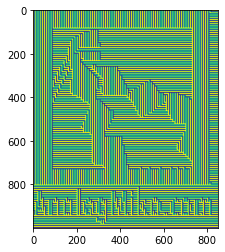

In [383]:
# Constant Spacing
imgname = 'AMK'
gapsize = 1;
k = Image.open(imgname+'.png').convert('L')
ksize = k.size
k_target_h = 85; # Unit is 5 um
k_scaling  = k_target_h/ksize[0]
ksize1 = np.dot(ksize,k_scaling).astype(int)
ksize2 = [ksize1[0],    ksize1[1]*10]
ksize3 = [ksize1[0]*10, ksize1[1]*10]
kr = np.array(k.resize(ksize1))
kr_dithered = (dither(kr, k_stucki,16)<<2);
kr_ditq = (dither(kr, k_stucki,16)<<2)>128;
strel = np.ones((gapsize, gapsize))
kr_ditq_di = ~binary_dilation(kr_ditq, structure=strel)

kr_dithered_10x   = np.array(Image.fromarray(kr_ditq).resize(ksize3,Image.NEAREST))
kr_dithered_10x_i = np.array(Image.fromarray(kr_ditq_di).resize(ksize3,Image.NEAREST))

kr_dithered_10x = kr_dithered_10x.transpose()
for i in range(ksize3[0]):
    if((i%10)>=6):
        kr_dithered_10x[i] = 0
kr_dithered_10x = kr_dithered_10x.transpose()


for i in range(ksize3[1]):
    if((i%10)>=6):
        kr_dithered_10x_i[i] = 0
kr_final = kr_dithered_10x + kr_dithered_10x_i;

plt.imshow(kr_final)
plt.imsave(imgname+'_hv.png',kr_final)
kr_dithered_10x_i = np.array(Image.fromarray(kr_dithered).resize(ksize3))

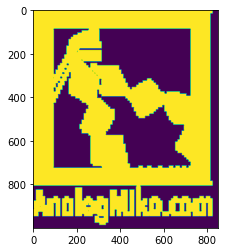

In [334]:
## kr_dithered_10x
import numpy as np
from scipy.ndimage.morphology import binary_dilation
strel = np.ones((4, 4))
dilated = binary_dilation(kr_dithered_10x_i, structure=strel)
plt.imshow(dilated)

In [279]:
import sys
import os
import numpy as np
from PIL import Image
from math import sqrt

k_fs = [
        0,0,0,7,0,
        0,3,5,1,0,
        0,0,0,0,0
    ]


k_jjn = [
        0,0,0,7,5,
        3,5,7,5,3,
        1,3,5,3,1
    ]


k_stucki = [
        0,0,0,8,4,
        2,4,8,4,2,
        1,2,4,2,1
    ]


k_s2 = [
        0,0,0,4,3,
        1,2,3,2,1,
        0,0,0,0,0
    ]

k_s3 = [
        0,0,0,5,3,
        2,4,5,4,2,
        0,2,3,2,0
    ]

k_s24a = [
        0,0,0,2,0,
        0,1,1,0,0,
        0,0,0,0,0
    ]


def dither(image, kernel, strength=1):
    pixels = image.copy()>>2
    xl = pixels.shape[0]
    yl = pixels.shape[1]

    DIV_FACTOR = sum(kernel)
    print("DIV FACTOR:", DIV_FACTOR)
    for y in range(yl):
        for x in range(xl):
            oldpixel = pixels[x][y]
            newpixel = 63*(oldpixel>31)
            pixels[x][y] = newpixel
            quant_error = (oldpixel - newpixel)/strength

            if (x<xl-1):
                pixels[x+1][y]   += quant_error*kernel[3]/DIV_FACTOR
            if (x<xl-2):
                pixels[x+2][y]   += quant_error*kernel[4]/DIV_FACTOR
                
            if (y<yl-1):
                if (x>1):
                    pixels[x-2][y+1] += quant_error*kernel[5]/DIV_FACTOR
                if (x>0):
                    pixels[x-1][y+1] += quant_error*kernel[6]/DIV_FACTOR
                    pixels[x][y+1]   += quant_error*kernel[7]/DIV_FACTOR
                if (x<xl-1):
                    pixels[x+1][y+1] += quant_error*kernel[8]/DIV_FACTOR
                if (x<xl-2):
                    pixels[x+2][y+1] += quant_error*kernel[9]/DIV_FACTOR
                
            if (y<yl-2):
                if (x>1):
                    pixels[x-2][y+2] += quant_error*kernel[10]/DIV_FACTOR
                if (x>0):
                    pixels[x-1][y+2] += quant_error*kernel[11]/DIV_FACTOR
                    pixels[x][y+2]   += quant_error*kernel[12]/DIV_FACTOR
                if (x<xl-1):
                    pixels[x+1][y+2] += quant_error*kernel[13]/DIV_FACTOR
                if (x<xl-2):
                    pixels[x+2][y+2] += quant_error*kernel[14]/DIV_FACTOR
 
    return pixels


filename = 'AMK.png'
ai = np.array(Image.open(filename).convert('L'),"int16")
img = Image.fromarray(dither(ai, k_stucki,2)<<2)
img.show()

# Note: Stucki is one of the few that can work with pure integer

DIV FACTOR: 42
